In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler



device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)



cuda


In [2]:
df1 = df.copy()


df1.dropna(inplace=True)

df_train = df1.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length - 1):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [3]:

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
bidirectional_lstm = BiLSTM(input_size=1,hidden_size=256,num_layers=1,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=bidirectional_lstm.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

In [5]:
for epoch in range(epochs):
    y_pred = bidirectional_lstm(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    bidirectional_lstm.eval()
    with torch.no_grad():
        y_pred = bidirectional_lstm(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  bidirectional_lstm(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')
        

C:\Users\katsa\AppData\Local\Temp\ipykernel_21468\3037039946.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_21468\3037039946.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4214; Test RSME: 0.107
Epoch: 1; train_RSEM: 0.3927; Test RSME: 0.08031
Epoch: 2; train_RSEM: 0.364; Test RSME: 0.056
Epoch: 3; train_RSEM: 0.3349; Test RSME: 0.03997
Epoch: 4; train_RSEM: 0.3053; Test RSME: 0.04531
Epoch: 5; train_RSEM: 0.2752; Test RSME: 0.06981
Epoch: 6; train_RSEM: 0.245; Test RSME: 0.103
Epoch: 7; train_RSEM: 0.2161; Test RSME: 0.1415
Epoch: 8; train_RSEM: 0.1913; Test RSME: 0.1844
Epoch: 9; train_RSEM: 0.1762; Test RSME: 0.2312
Epoch: 10; train_RSEM: 0.1763; Test RSME: 0.2793
Epoch: 11; train_RSEM: 0.1903; Test RSME: 0.3225
Epoch: 12; train_RSEM: 0.2062; Test RSME: 0.3517
Epoch: 13; train_RSEM: 0.2133; Test RSME: 0.3622
Epoch: 14; train_RSEM: 0.2098; Test RSME: 0.3567
Epoch: 15; train_RSEM: 0.1992; Test RSME: 0.3401
Epoch: 16; train_RSEM: 0.1862; Test RSME: 0.3172
Epoch: 17; train_RSEM: 0.1746; Test RSME: 0.2917
Epoch: 18; train_RSEM: 0.1667; Test RSME: 0.2664
Epoch: 19; train_RSEM: 0.163; Test RSME: 0.2432
Epoch: 20; train_RSEM: 0.1626; T

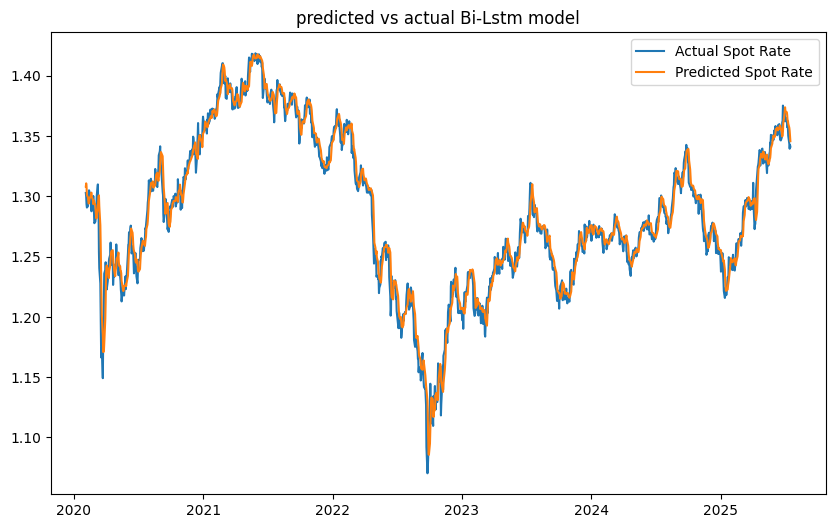

In [6]:
with torch.no_grad():
    pred = bidirectional_lstm(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df1.iloc[train_size + seq_length: -1]['Date']


bilstm_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(bilstm_comparison_df['Date'],bilstm_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual Bi-Lstm model")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_bidirectional_lstm.png")
plt.show()

In [7]:
print(np.round(bilstm_comparison_df,4).head(20))
print(np.round(bilstm_comparison_df,4).tail(20))


            Date  Actual Spot Rate  Predicted Spot Rate
12314 2020-02-04            1.3029               1.3082
12315 2020-02-05            1.3000               1.3109
12316 2020-02-06            1.2935               1.3087
12317 2020-02-07            1.2908               1.3010
12318 2020-02-10            1.2919               1.2994
12319 2020-02-11            1.2945               1.2963
12320 2020-02-12            1.2978               1.2941
12321 2020-02-13            1.3051               1.2946
12322 2020-02-14            1.3039               1.2977
12323 2020-02-18            1.3017               1.3005
12324 2020-02-19            1.2934               1.3030
12325 2020-02-20            1.2877               1.3032
12326 2020-02-21            1.2966               1.2995
12327 2020-02-24            1.2923               1.2973
12328 2020-02-25            1.3004               1.2936
12329 2020-02-26            1.2921               1.2949
12330 2020-02-27            1.2876              